# 1. Initial Setup

## 1.1 Import libraries

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow
import numpy as np
from numpy.random import seed
import pandas as pd
import openpyxl
from datetime import date, datetime, timedelta
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Add, Multiply, Concatenate, Dropout, MaxPool1D, Bidirectional
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.regularizers import L2

# set global random seed
seed(1309)
tensorflow.random.set_seed(1309)

Using TensorFlow backend.


## 1.2 Hyperparameters

In [3]:
# Hyperparameters
my_batch_size=72
my_epochs=50
my_optimizer=RMSprop()
my_validation_split=0.10
my_shuffle=True
my_regulizer=L2(l2=0.000001)
#my_optimizer='rmsprop' 
#rmsprop = 0.001 learning rate

# 2. Required Functions

In [4]:
# Function to resample into 15 minute intervals
def operation(date, block):
    return date + timedelta(minutes=15 * (block))

# Function to prepare data based on number of houses
def create_datetime_column(df):
    df['date'] = pd.to_datetime(df['date'])
    # we need the block and date columns to create a date_time index column
    df["date_time"]=list(map(lambda x,y: operation(datetime.strptime(x.strftime("%Y-%m-%d"),"%Y-%m-%d"),y), df['date'],df["block"]))
    #list_of_houses[idx]=list_of_houses[idx].set_index('date_time')
    # missing dates
    #missing_dates = pd.date_range(start = '2018-07-10 00:00:00', end = '2020-06-30 23:45:00' ,freq="15T").difference(list_of_houses[idx].index)
    #list_of_houses[idx]=list_of_houses[idx].reindex(pd.date_range(start = '2018-07-10 00:00:00', end = '2020-06-30 23:45:00' ,freq="15T"))
    # drop date ans block columns, we now have a proper datetime index
    df = df.drop('date', 1)
    #df = df.drop('block', 1)
    print(df.head())
        
    print("Nulls:\n")
    print(df.isna().any())
    
    return df

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def create_dataset(dataset, number_of_features, look_back=1 ):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0:number_of_features] 
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def pre_process(df,look_back):
    series = df
    series = series.astype(float)

    series = series.values
    scaler = MinMaxScaler(feature_range=(1, 2))
    #scaler = StandardScaler()
    series = scaler.fit_transform(series)

    train_size = int(len(series) * 0.80)
    test_size = len(series) - train_size
    train, test = series[0:train_size,:], series[train_size:len(series),:]
    print("Length of train and test")
    print(len(train), len(test))
    columns = len(df.columns)
    print("Total number of columns = "+str(columns))
    print("Creating dataset with look back = "+str(look_back))
    trainX, trainY = create_dataset(train, columns,look_back)
    testX, testY = create_dataset(test, columns, look_back)
    print("\nShape of train X and Y:")
    print(trainX.shape, trainY.shape)
    print("\nShape of test X and Y:")
    print(testX.shape, testY.shape)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], columns))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], columns))

    print("\nShape of train X and Y after reshaping:")
    print(trainX.shape, trainY.shape)
    
    return trainX, trainY, testX, testY, series, columns

# 3. Import data

## 3.1 Energy data

In [5]:
energy_data = pd.read_csv("emarc_with_datetime.csv")
energy_data['date_time'] = pd.to_datetime(energy_data['date_time'])

In [6]:
# pick only the Mainline values
energy_data_mainline = energy_data.loc[energy_data['Deployment type'] == "Mainline"]

In [7]:
# Using for loop (138 Mainline deployments)
mainline_by_deployment_id = [group.reset_index()[['deployment_id','block','date_time','Load (kW)','Deployment type','Region','Household type']] for _, group in energy_data_mainline.groupby('deployment_id')]

# print date ranges (113 Mainline deployments have end date June 30 2020)

ending_june_30_2020 = []
for idx, val in enumerate(mainline_by_deployment_id):
    #val['date_time'] = pd.to_datetime(df['Date']) # If your Date column is of the type object otherwise skip this
    date_range = str(val['date_time'].dt.date.min()) + ' to ' +str(val['date_time'].dt.date.max())
    if str(val['date_time'].dt.date.max()) == "2020-06-30":
           ending_june_30_2020.append(val)

print("number of June 30 2020 deployments:" + str(len(ending_june_30_2020)))

# create a uniform date range for all deployments
# smallest range --> 2019-07-14 to 2020-06-30
# ok go ahead and do the smallest date range just so we can try the clustering thing as accurate as possible
jul72019_jun302020 = []

for idx, val in enumerate(ending_june_30_2020):
    val = val.sort_values('date_time')
    val = val[(val['date_time'] >= '2019-07-14') & (val['date_time'] <= '2020-07-01')]
    jul72019_jun302020.append(val)

# We have here the Jul 14th 2019 to June 30 2020 datasets
print(len(jul72019_jun302020))
jul72019_jun302020_withoutNaN = []

for idx, val in enumerate(jul72019_jun302020):
    # set date time as an index
    val=val.set_index('date_time')
    
    # then reindex based on required range (expected shape (33888, 6))
    val=val.reindex(pd.date_range(start = '2019-07-14', end = '2020-06-30 23:45:00' ,freq="15T"))
    if val.isnull().values.any() == False:
        jul72019_jun302020_withoutNaN.append(val)
    
# 71 houses without NaNs in the required range
print(len(jul72019_jun302020_withoutNaN))  

# Add date column and reindex & create train, test split
required_date_range_reindexed = []

for idx, val in enumerate(jul72019_jun302020_withoutNaN):
    val['date_time'] = val.index
    val['date'] = pd.to_datetime(val['date_time']).dt.date
    val = val.reset_index()
    required_date_range_reindexed.append(val)

number of June 30 2020 deployments:113
113
71


## 3.2 Mobility data

In [8]:
# read the CSV file
mobility = pd.read_csv("2020_IN_Region_Mobility_Report.csv")

# choose only Pune rows
mobility = mobility.loc[mobility['sub_region_2'] == "Pune"]
# choose important columns
mobility = mobility.iloc[:,8:]

mobility['date'] = pd.to_datetime(mobility['date'], format='%Y-%m-%d')
mobility = mobility.pivot(index='date', columns='retail_and_recreation_percent_change_from_baseline')

#start_date = mobility.index.min() - pd.DateOffset(hour=0)
#end_date = mobility.index.max() + pd.DateOffset(hour=23)
dates = pd.date_range("2020-02-15 00:00:00", "2020-06-30 23:45:00", freq='15T')
dates.name = 'date'
mobility = mobility.reindex(dates, method='ffill')

mobility = mobility.stack('retail_and_recreation_percent_change_from_baseline')
mobility = mobility.reset_index()
mobility = mobility.set_index('date')

### 3.2.1 Plot for insights

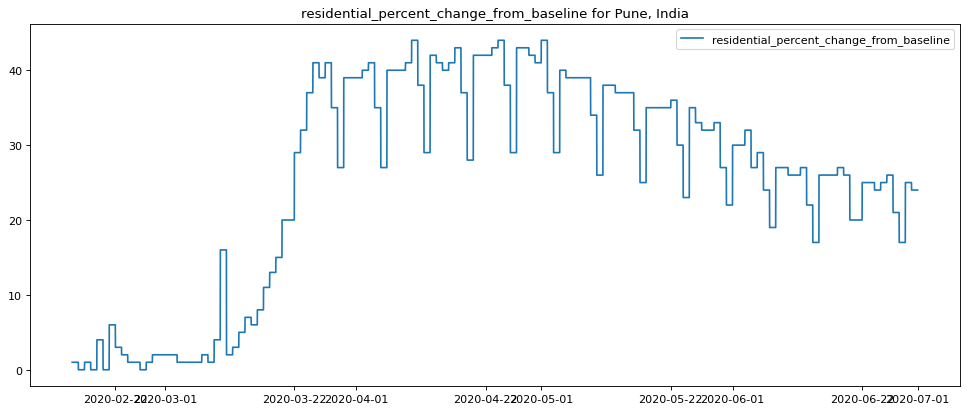

In [9]:
# Plot some mobility curves
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(mobility['residential_percent_change_from_baseline'], label='residential_percent_change_from_baseline')
plt.title("residential_percent_change_from_baseline for Pune, India")
plt.legend()
plt.show()

## 3.3 Weather data

In [10]:
pune_weather = pd.read_csv('Pune.csv', header=0) 

# retrieve useful columns only
pune_weather = pune_weather[['date_time','tempC','FeelsLikeC','pressure','cloudcover','humidity','winddirDegree','windspeedKmph']]

# resample weather data to 15-minute intervals
pune_weather['date_time'] = pd.to_datetime(pune_weather['date_time'])
pune_weather = pune_weather.set_index('date_time') 
pune_weather=pune_weather.resample('15T').fillna('pad')
pune_weather=pune_weather.reindex(pd.date_range(start = '2018-01-01', end = '2020-06-30 23:45:00' ,freq="15T"))
pune_weather=pune_weather.fillna(method='pad')
pune_weather['date_time']=pune_weather.index

# 4. Model A --> Multi-task learning

## 4.1 Pre-process data for training on multiple houses

In [11]:
pune_weather_houses = pune_weather[(pune_weather['date_time'] >= '2019-07-14') & (pune_weather['date_time'] <= '2020-12-01')]

pune=[]

#evaluation_house_x_test_before_covid,evaluation_house_x_test_after_covid], evaluation_house_y_test_after_covid
x_test_before_covid_list = []
x_test_after_covid_list = []
y_test_after_covid_list = []


for idx, val in enumerate(required_date_range_reindexed):
    if("Pune" in val['Region'][0]):
        pune.append(val)
        
print(len(pune))
print(pune[0].head())

for idx, val in enumerate(pune):
    pune[idx] = pd.merge_asof(pune_weather_houses, pune[idx], on="date_time")

    before_covid = pune[idx][(pune[idx]['date_time'] < '2020-02-15')]

    after_covid = pune[idx][(pune[idx]['date_time'] >= '2020-02-15') & (pune[idx]['date_time'] < '2020-12-31')]
    after_covid=after_covid.drop('date',axis=1)
    after_covid['date'] = pd.to_datetime(after_covid['date_time']).dt.date
    after_covid['date'] =  pd.to_datetime(after_covid['date'], format='%Y-%m-%d')

    after_covid = pd.merge_asof(after_covid, mobility, on="date")


    # retrieve useful columns only
    after_covid_final = after_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph',
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    ]]


    before_covid_final = before_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph'
    ]]


    # set 'date_time' as index
    before_covid_final=before_covid_final.set_index('date_time')
    after_covid_final=after_covid_final.set_index('date_time')

    before__covid_trainX, before__covid_trainY, before__covid_testX, before__covid_testY , before__covid_series, before__covid_columns= pre_process(before_covid_final,20)
    after__covid_trainX, after__covid_trainY, after__covid_testX, after__covid_testY , after__covid_series, after__covid_columns= pre_process(after_covid_final,20)
    
    reduced_before_covid_train_X = before__covid_trainX[6067:,:,:]
    print(reduced_before_covid_train_X.shape)
    
    
    if (idx == 0):
        full_before_covid_trainX = reduced_before_covid_train_X
        full_after_covid_trainX = after__covid_trainX
        
        full_before__covid_trainY = before__covid_trainY
        full_after__covid_trainY = after__covid_trainY
        
        full_before__covid_testX = before__covid_testX
        full_after__covid_testX = after__covid_testX
        
        full_before__covid_testY = before__covid_testY
        full_after__covid_testY = after__covid_testY
    else:
        full_before_covid_trainX = np.append(full_before_covid_trainX,reduced_before_covid_train_X,0)
        full_after_covid_trainX = np.append(full_after_covid_trainX,after__covid_trainX,0)
        
        full_before__covid_trainY = np.append(full_before__covid_trainY,before__covid_trainY,0)
        full_after__covid_trainY = np.append(full_after__covid_trainY,after__covid_trainY,0)
        
        full_before__covid_testX = np.append(full_before__covid_testX,before__covid_testX,0)
        full_after__covid_testX = np.append(full_after__covid_testX,after__covid_testX,0)
        
        full_before__covid_testY = np.append(full_before__covid_testY,before__covid_testY,0)
        full_after__covid_testY = np.append(full_after__covid_testY,after__covid_testY,0)
    
    x_test_before_covid_list.append(before__covid_testX)
    x_test_after_covid_list.append(after__covid_testX)
    y_test_after_covid_list.append(after__covid_testY)
    
        
full_before__covid_testX = full_before__covid_testX[57646:,:,:]

38
                index deployment_id  block  Load (kW) Deployment type  \
0 2019-07-14 00:00:00         D0004      0   0.114241        Mainline   
1 2019-07-14 00:15:00         D0004      1   0.124451        Mainline   
2 2019-07-14 00:30:00         D0004      2   0.234375        Mainline   
3 2019-07-14 00:45:00         D0004      3   0.256488        Mainline   
4 2019-07-14 01:00:00         D0004      4   0.220941        Mainline   

      Region         Household type           date_time        date  
0  Pune city  With Air Conditioners 2019-07-14 00:00:00  2019-07-14  
1  Pune city  With Air Conditioners 2019-07-14 00:15:00  2019-07-14  
2  Pune city  With Air Conditioners 2019-07-14 00:30:00  2019-07-14  
3  Pune city  With Air Conditioners 2019-07-14 00:45:00  2019-07-14  
4  Pune city  With Air Conditioners 2019-07-14 01:00:00  2019-07-14  
Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 20

Shape of train X and Y:
(16567, 20, 

Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 20

Shape of train X and Y:
(16567, 20, 8) (16567,)

Shape of test X and Y:
(4127, 20, 8) (4127,)

Shape of train X and Y after reshaping:
(16567, 20, 8) (16567,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 20

Shape of train X and Y:
(10500, 20, 14) (10500,)

Shape of test X and Y:
(2610, 20, 14) (2610,)

Shape of train X and Y after reshaping:
(10500, 20, 14) (10500,)
(10500, 20, 8)
Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 20

Shape of train X and Y:
(16567, 20, 8) (16567,)

Shape of test X and Y:
(4127, 20, 8) (4127,)

Shape of train X and Y after reshaping:
(16567, 20, 8) (16567,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 20

Shape of train X and Y:
(10500, 20, 14) (10500,)

Shape of test X and Y:
(2610, 20, 14) (2610,)

Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 20

Shape of train X and Y:
(16567, 20, 8) (16567,)

Shape of test X and Y:
(4127, 20, 8) (4127,)

Shape of train X and Y after reshaping:
(16567, 20, 8) (16567,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 20

Shape of train X and Y:
(10500, 20, 14) (10500,)

Shape of test X and Y:
(2610, 20, 14) (2610,)

Shape of train X and Y after reshaping:
(10500, 20, 14) (10500,)
(10500, 20, 8)
Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 20

Shape of train X and Y:
(16567, 20, 8) (16567,)

Shape of test X and Y:
(4127, 20, 8) (4127,)

Shape of train X and Y after reshaping:
(16567, 20, 8) (16567,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 20

Shape of train X and Y:
(10500, 20, 14) (10500,)

Shape of test X and Y:
(2610, 20, 14) (2610,)

In [34]:
full_before_covid_trainX_20 = full_before_covid_trainX
full_after_covid_trainX_20 = full_after_covid_trainX
        
full_before__covid_trainY_20 = full_before__covid_trainY
full_after__covid_trainY_20 = full_after__covid_trainY

full_before__covid_testX_20 = full_before__covid_testX
full_after__covid_testX_20 = full_after__covid_testX
        
full_before__covid_testY_20 = full_before__covid_testY
full_after__covid_testY_20 = full_after__covid_testY

In [37]:
pune_weather_houses = pune_weather[(pune_weather['date_time'] >= '2019-07-14') & (pune_weather['date_time'] <= '2020-12-01')]

pune=[]

#evaluation_house_x_test_before_covid,evaluation_house_x_test_after_covid], evaluation_house_y_test_after_covid
x_test_before_covid_list_80 = []
x_test_after_covid_list_80 = []
y_test_after_covid_list_80 = []


for idx, val in enumerate(required_date_range_reindexed):
    if("Pune" in val['Region'][0]):
        pune.append(val)
        
print(len(pune))
print(pune[0].head())

for idx, val in enumerate(pune):
    pune[idx] = pd.merge_asof(pune_weather_houses, pune[idx], on="date_time")

    before_covid = pune[idx][(pune[idx]['date_time'] < '2020-02-15')]

    after_covid = pune[idx][(pune[idx]['date_time'] >= '2020-02-15') & (pune[idx]['date_time'] < '2020-12-31')]
    after_covid=after_covid.drop('date',axis=1)
    after_covid['date'] = pd.to_datetime(after_covid['date_time']).dt.date
    after_covid['date'] =  pd.to_datetime(after_covid['date'], format='%Y-%m-%d')

    after_covid = pd.merge_asof(after_covid, mobility, on="date")


    # retrieve useful columns only
    after_covid_final = after_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph',
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    ]]


    before_covid_final = before_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph'
    ]]


    # set 'date_time' as index
    before_covid_final=before_covid_final.set_index('date_time')
    after_covid_final=after_covid_final.set_index('date_time')

    before__covid_trainX, before__covid_trainY, before__covid_testX, before__covid_testY , before__covid_series, before__covid_columns= pre_process(before_covid_final,80)
    after__covid_trainX, after__covid_trainY, after__covid_testX, after__covid_testY , after__covid_series, after__covid_columns= pre_process(after_covid_final,80)
    
    reduced_before_covid_train_X = before__covid_trainX[6067:,:,:]
    print(reduced_before_covid_train_X.shape)
    
    
    if (idx == 0):
        full_before_covid_trainX = reduced_before_covid_train_X
        full_after_covid_trainX = after__covid_trainX
        
        full_before__covid_trainY = before__covid_trainY
        full_after__covid_trainY = after__covid_trainY
        
        full_before__covid_testX = before__covid_testX
        full_after__covid_testX = after__covid_testX
        
        full_before__covid_testY = before__covid_testY
        full_after__covid_testY = after__covid_testY
    else:
        full_before_covid_trainX = np.append(full_before_covid_trainX,reduced_before_covid_train_X,0)
        full_after_covid_trainX = np.append(full_after_covid_trainX,after__covid_trainX,0)
        
        full_before__covid_trainY = np.append(full_before__covid_trainY,before__covid_trainY,0)
        full_after__covid_trainY = np.append(full_after__covid_trainY,after__covid_trainY,0)
        
        full_before__covid_testX = np.append(full_before__covid_testX,before__covid_testX,0)
        full_after__covid_testX = np.append(full_after__covid_testX,after__covid_testX,0)
        
        full_before__covid_testY = np.append(full_before__covid_testY,before__covid_testY,0)
        full_after__covid_testY = np.append(full_after__covid_testY,after__covid_testY,0)
    
    x_test_before_covid_list_80.append(before__covid_testX)
    x_test_after_covid_list_80.append(after__covid_testX)
    y_test_after_covid_list_80.append(after__covid_testY)
    
        
full_before__covid_testX = full_before__covid_testX[57646:,:,:]

38
                index deployment_id  block  Load (kW) Deployment type  \
0 2019-07-14 00:00:00         D0004      0   0.114241        Mainline   
1 2019-07-14 00:15:00         D0004      1   0.124451        Mainline   
2 2019-07-14 00:30:00         D0004      2   0.234375        Mainline   
3 2019-07-14 00:45:00         D0004      3   0.256488        Mainline   
4 2019-07-14 01:00:00         D0004      4   0.220941        Mainline   

      Region         Household type           date_time        date  
0  Pune city  With Air Conditioners 2019-07-14 00:00:00  2019-07-14  
1  Pune city  With Air Conditioners 2019-07-14 00:15:00  2019-07-14  
2  Pune city  With Air Conditioners 2019-07-14 00:30:00  2019-07-14  
3  Pune city  With Air Conditioners 2019-07-14 00:45:00  2019-07-14  
4  Pune city  With Air Conditioners 2019-07-14 01:00:00  2019-07-14  
Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 80

Shape of train X and Y:
(16507, 80, 

Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 80

Shape of train X and Y:
(16507, 80, 8) (16507,)

Shape of test X and Y:
(4067, 80, 8) (4067,)

Shape of train X and Y after reshaping:
(16507, 80, 8) (16507,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 80

Shape of train X and Y:
(10440, 80, 14) (10440,)

Shape of test X and Y:
(2550, 80, 14) (2550,)

Shape of train X and Y after reshaping:
(10440, 80, 14) (10440,)
(10440, 80, 8)
Length of train and test
16588 4148
Total number of columns = 8
Creating dataset with look back = 80

Shape of train X and Y:
(16507, 80, 8) (16507,)

Shape of test X and Y:
(4067, 80, 8) (4067,)

Shape of train X and Y after reshaping:
(16507, 80, 8) (16507,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 80

Shape of train X and Y:
(10440, 80, 14) (10440,)

Shape of test X and Y:
(2550, 80, 14) (2550,)


Shape of train X and Y:
(16507, 80, 8) (16507,)

Shape of test X and Y:
(4067, 80, 8) (4067,)

Shape of train X and Y after reshaping:
(16507, 80, 8) (16507,)
Length of train and test
10521 2631
Total number of columns = 14
Creating dataset with look back = 80

Shape of train X and Y:
(10440, 80, 14) (10440,)

Shape of test X and Y:
(2550, 80, 14) (2550,)

Shape of train X and Y after reshaping:
(10440, 80, 14) (10440,)
(10440, 80, 8)


KeyboardInterrupt: 

In [ ]:
full_before_covid_trainX_80 = full_before_covid_trainX
full_after_covid_trainX_80 = full_after_covid_trainX
        
full_before__covid_trainY_80 = full_before__covid_trainY
full_after__covid_trainY_80 = full_after__covid_trainY

full_before__covid_testX_80 = full_before__covid_testX
full_after__covid_testX_80 = full_after__covid_testX
        
full_before__covid_testY_80 = full_before__covid_testY
full_after__covid_testY_80 = full_after__covid_testY

In [ ]:
pune_weather_houses = pune_weather[(pune_weather['date_time'] >= '2019-07-14') & (pune_weather['date_time'] <= '2020-12-01')]

pune=[]

#evaluation_house_x_test_before_covid,evaluation_house_x_test_after_covid], evaluation_house_y_test_after_covid
x_test_before_covid_list_60 = []
x_test_after_covid_list_60 = []
y_test_after_covid_list_60 = []


for idx, val in enumerate(required_date_range_reindexed):
    if("Pune" in val['Region'][0]):
        pune.append(val)
        
print(len(pune))
print(pune[0].head())

for idx, val in enumerate(pune):
    pune[idx] = pd.merge_asof(pune_weather_houses, pune[idx], on="date_time")

    before_covid = pune[idx][(pune[idx]['date_time'] < '2020-02-15')]

    after_covid = pune[idx][(pune[idx]['date_time'] >= '2020-02-15') & (pune[idx]['date_time'] < '2020-12-31')]
    after_covid=after_covid.drop('date',axis=1)
    after_covid['date'] = pd.to_datetime(after_covid['date_time']).dt.date
    after_covid['date'] =  pd.to_datetime(after_covid['date'], format='%Y-%m-%d')

    after_covid = pd.merge_asof(after_covid, mobility, on="date")


    # retrieve useful columns only
    after_covid_final = after_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph',
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    ]]


    before_covid_final = before_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph'
    ]]


    # set 'date_time' as index
    before_covid_final=before_covid_final.set_index('date_time')
    after_covid_final=after_covid_final.set_index('date_time')

    before__covid_trainX, before__covid_trainY, before__covid_testX, before__covid_testY , before__covid_series, before__covid_columns= pre_process(before_covid_final,60)
    after__covid_trainX, after__covid_trainY, after__covid_testX, after__covid_testY , after__covid_series, after__covid_columns= pre_process(after_covid_final,60)
    
    reduced_before_covid_train_X = before__covid_trainX[6067:,:,:]
    print(reduced_before_covid_train_X.shape)
    
    
    if (idx == 0):
        full_before_covid_trainX = reduced_before_covid_train_X
        full_after_covid_trainX = after__covid_trainX
        
        full_before__covid_trainY = before__covid_trainY
        full_after__covid_trainY = after__covid_trainY
        
        full_before__covid_testX = before__covid_testX
        full_after__covid_testX = after__covid_testX
        
        full_before__covid_testY = before__covid_testY
        full_after__covid_testY = after__covid_testY
    else:
        full_before_covid_trainX = np.append(full_before_covid_trainX,reduced_before_covid_train_X,0)
        full_after_covid_trainX = np.append(full_after_covid_trainX,after__covid_trainX,0)
        
        full_before__covid_trainY = np.append(full_before__covid_trainY,before__covid_trainY,0)
        full_after__covid_trainY = np.append(full_after__covid_trainY,after__covid_trainY,0)
        
        full_before__covid_testX = np.append(full_before__covid_testX,before__covid_testX,0)
        full_after__covid_testX = np.append(full_after__covid_testX,after__covid_testX,0)
        
        full_before__covid_testY = np.append(full_before__covid_testY,before__covid_testY,0)
        full_after__covid_testY = np.append(full_after__covid_testY,after__covid_testY,0)
    
    x_test_before_covid_list_60.append(before__covid_testX)
    x_test_after_covid_list_60.append(after__covid_testX)
    y_test_after_covid_list_60.append(after__covid_testY)
    
        
full_before__covid_testX = full_before__covid_testX[57646:,:,:]

In [ ]:
full_before_covid_trainX_60 = full_before_covid_trainX
full_after_covid_trainX_60 = full_after_covid_trainX
        
full_before__covid_trainY_60 = full_before__covid_trainY
full_after__covid_trainY_60 = full_after__covid_trainY

full_before__covid_testX_60 = full_before__covid_testX
full_after__covid_testX_60 = full_after__covid_testX
        
full_before__covid_testY_60 = full_before__covid_testY
full_after__covid_testY_60 = full_after__covid_testY

In [ ]:
pune_weather_houses = pune_weather[(pune_weather['date_time'] >= '2019-07-14') & (pune_weather['date_time'] <= '2020-12-01')]

pune=[]

#evaluation_house_x_test_before_covid,evaluation_house_x_test_after_covid], evaluation_house_y_test_after_covid
x_test_before_covid_list_40 = []
x_test_after_covid_list_40 = []
y_test_after_covid_list_40 = []


for idx, val in enumerate(required_date_range_reindexed):
    if("Pune" in val['Region'][0]):
        pune.append(val)
        
print(len(pune))
print(pune[0].head())

for idx, val in enumerate(pune):
    pune[idx] = pd.merge_asof(pune_weather_houses, pune[idx], on="date_time")

    before_covid = pune[idx][(pune[idx]['date_time'] < '2020-02-15')]

    after_covid = pune[idx][(pune[idx]['date_time'] >= '2020-02-15') & (pune[idx]['date_time'] < '2020-12-31')]
    after_covid=after_covid.drop('date',axis=1)
    after_covid['date'] = pd.to_datetime(after_covid['date_time']).dt.date
    after_covid['date'] =  pd.to_datetime(after_covid['date'], format='%Y-%m-%d')

    after_covid = pd.merge_asof(after_covid, mobility, on="date")


    # retrieve useful columns only
    after_covid_final = after_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph',
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    ]]


    before_covid_final = before_covid[[
        'date_time',
        'Load (kW)',
        'tempC',
        'FeelsLikeC',
        'pressure',
        'cloudcover',
        'humidity',
        'winddirDegree',
        'windspeedKmph'
    ]]


    # set 'date_time' as index
    before_covid_final=before_covid_final.set_index('date_time')
    after_covid_final=after_covid_final.set_index('date_time')

    before__covid_trainX, before__covid_trainY, before__covid_testX, before__covid_testY , before__covid_series, before__covid_columns= pre_process(before_covid_final,40)
    after__covid_trainX, after__covid_trainY, after__covid_testX, after__covid_testY , after__covid_series, after__covid_columns= pre_process(after_covid_final,40)
    
    reduced_before_covid_train_X = before__covid_trainX[6067:,:,:]
    print(reduced_before_covid_train_X.shape)
    
    
    if (idx == 0):
        full_before_covid_trainX = reduced_before_covid_train_X
        full_after_covid_trainX = after__covid_trainX
        
        full_before__covid_trainY = before__covid_trainY
        full_after__covid_trainY = after__covid_trainY
        
        full_before__covid_testX = before__covid_testX
        full_after__covid_testX = after__covid_testX
        
        full_before__covid_testY = before__covid_testY
        full_after__covid_testY = after__covid_testY
    else:
        full_before_covid_trainX = np.append(full_before_covid_trainX,reduced_before_covid_train_X,0)
        full_after_covid_trainX = np.append(full_after_covid_trainX,after__covid_trainX,0)
        
        full_before__covid_trainY = np.append(full_before__covid_trainY,before__covid_trainY,0)
        full_after__covid_trainY = np.append(full_after__covid_trainY,after__covid_trainY,0)
        
        full_before__covid_testX = np.append(full_before__covid_testX,before__covid_testX,0)
        full_after__covid_testX = np.append(full_after__covid_testX,after__covid_testX,0)
        
        full_before__covid_testY = np.append(full_before__covid_testY,before__covid_testY,0)
        full_after__covid_testY = np.append(full_after__covid_testY,after__covid_testY,0)
    
    x_test_before_covid_list_40.append(before__covid_testX)
    x_test_after_covid_list_40.append(after__covid_testX)
    y_test_after_covid_list_40.append(after__covid_testY)
    
        
full_before__covid_testX = full_before__covid_testX[57646:,:,:]

In [ ]:
full_before_covid_trainX_40 = full_before_covid_trainX
full_after_covid_trainX_40 = full_after_covid_trainX
        
full_before__covid_trainY_40 = full_before__covid_trainY
full_after__covid_trainY_40 = full_after__covid_trainY

full_before__covid_testX_40 = full_before__covid_testX
full_after__covid_testX_40 = full_after__covid_testX
        
full_before__covid_testY_40 = full_before__covid_testY
full_after__covid_testY_40 = full_after__covid_testY

In [12]:
print("------------------------ TRAIN ------------------------")
# Training and test for all Pune houses
print(full_before_covid_trainX.shape)
print(full_after_covid_trainX.shape)

#print(full_before__covid_trainY.shape)
print(full_after__covid_trainY.shape)

print("------------------------ TEST ------------------------")

print(full_before__covid_testX.shape)
print(full_after__covid_testX.shape)

#print(full_before__covid_testY.shape)
print(full_after__covid_testY.shape)

------------------------ TRAIN ------------------------
(399000, 20, 8)
(399000, 20, 14)
(399000,)
------------------------ TEST ------------------------
(99180, 20, 8)
(99180, 20, 14)
(99180,)


In [ ]:
print("------------------------ TRAIN ------------------------")
# Training and test for all Pune houses
print(full_before_covid_trainX_40.shape)
print(full_after_covid_trainX_40.shape)

#print(full_before__covid_trainY.shape)
print(full_after__covid_trainY_40.shape)

print("------------------------ TEST ------------------------")

print(full_before__covid_testX_40.shape)
print(full_after__covid_testX_40.shape)

#print(full_before__covid_testY.shape)
print(full_after__covid_testY_40.shape)

In [ ]:
print("------------------------ TRAIN ------------------------")
# Training and test for all Pune houses
print(full_before_covid_trainX_60.shape)
print(full_after_covid_trainX_60.shape)

#print(full_before__covid_trainY.shape)
print(full_after__covid_trainY_60.shape)

print("------------------------ TEST ------------------------")

print(full_before__covid_testX_60.shape)
print(full_after__covid_testX_60.shape)

#print(full_before__covid_testY.shape)
print(full_after__covid_testY_60.shape)

In [ ]:
print("------------------------ TRAIN ------------------------")
# Training and test for all Pune houses
print(full_before_covid_trainX_80.shape)
print(full_after_covid_trainX_80.shape)

#print(full_before__covid_trainY.shape)
print(full_after__covid_trainY_80.shape)

print("------------------------ TEST ------------------------")

print(full_before__covid_testX_80.shape)
print(full_after__covid_testX_80.shape)

#print(full_before__covid_testY.shape)
print(full_after__covid_testY_80.shape)

## 4.2 Model

Building Multitask Model...
before_covid_input shape: (None, 20, 8)
after_covid_input shape: (None, 20, 9)
conv1d_before_covid shape: (None, 18, 32)
maxpool_before_covid shape: (None, 9, 32)
bidirectional_lstm_after_covid_1 shape: (None, 20, 64)
bidirectional_lstm_after_covid_2 shape: (None, 20, 32)
(None, 29, 32)
(None, 29, 32)
(None, 29, 32)
(None, 29, 96)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
after_covid_input (InputLayer)  [(None, 20, 9)]      0                                            
__________________________________________________________________________________________________
before_covid_input (InputLayer) [(None, 20, 8)]      0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirection

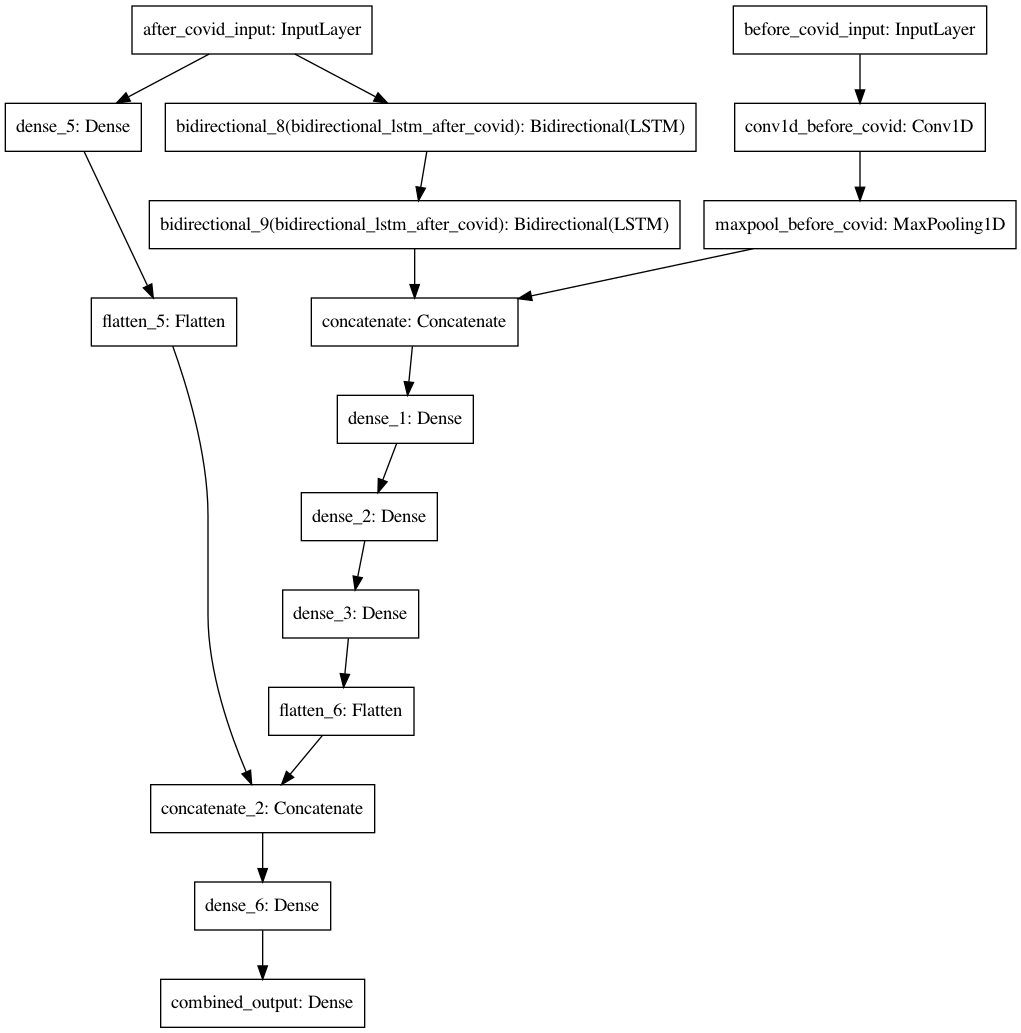

In [31]:
from tensorflow.python.keras.models import Sequential
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten
print('Building Multitask Model...')

# Input layer
before_covid_input = Input(shape=(20,before__covid_columns), name='before_covid_input')
print("before_covid_input shape: "+str(before_covid_input.shape))
after_covid_input = Input(shape=(20,after__covid_columns), name='after_covid_input')
dense_5 = Dense(96, activation='relu',name='dense_5',kernel_regularizer=my_regulizer)(after_covid_input)
flatten_1 = Flatten()(dense_5)

print("after_covid_input shape: "+str(after_covid_input.shape))

# second layer
conv1d_before_covid = Conv1D(32, 3, activation='relu',name='conv1d_before_covid')(before_covid_input)

print("conv1d_before_covid shape: "+str(conv1d_before_covid.shape))
maxpool_before_covid = MaxPool1D(name='maxpool_before_covid')(conv1d_before_covid)
print("maxpool_before_covid shape: "+str(maxpool_before_covid.shape))

# second layer
bidirectional_lstm_after_covid_1 = Bidirectional(LSTM(32, return_sequences=True, stateful=False,name='bidirectional_lstm_after_covid'), merge_mode='concat')(after_covid_input)
print("bidirectional_lstm_after_covid_1 shape: "+str(bidirectional_lstm_after_covid_1.shape))
bidirectional_lstm_after_covid_2 = Bidirectional(LSTM(16, return_sequences=True, stateful=False,name='bidirectional_lstm_after_covid'), merge_mode='concat')(bidirectional_lstm_after_covid_1)
print("bidirectional_lstm_after_covid_2 shape: "+str(bidirectional_lstm_after_covid_2.shape))

# Combine 2 layers into 1
#concatenate = Concatenate(name='concatenate')([before_covid_input, after_covid_input])
# [(None, 20, 100), (None, 9, 32)]
concatenate = Concatenate(name='concatenate',axis=1)([bidirectional_lstm_after_covid_2, maxpool_before_covid])

#bidirectional_lstm_common = Bidirectional(LSTM(50, return_sequences=True, stateful=False,name='lstm'), merge_mode='concat')(concatenate)
#dropout_1 = Dropout(0.5, name='dropout_1')(concatenate)
#bidirectional_lstm_common_2 = Bidirectional(LSTM(10, kernel_initializer="uniform",return_sequences=False, name='lstm2'),merge_mode='concat')(dropout_1)

print(concatenate.shape)

dense_1 = Dense(32, activation='relu',name='dense_1', kernel_regularizer=my_regulizer)(concatenate)
print(dense_1.shape)
dense_2 = Dense(32, activation='relu',name='dense_2',kernel_regularizer=my_regulizer)(dense_1)
print(dense_2.shape)
dense_3 = Dense(96, activation='relu',name='dense_3',kernel_regularizer=my_regulizer)(dense_2)
flatten_2 = Flatten()(dense_3)
#dense_4 = Dense(14, activation='relu',name='dense_4',kernel_regularizer=my_regulizer)(dense_3)

print(dense_3.shape)

concatenate_2 = Concatenate(name='concatenate_2',axis=1)([flatten_2, flatten_1])
dense_6 = Dense(96, activation='relu',name='dense_6',kernel_regularizer=my_regulizer)(concatenate_2)


    
# sequence output
combined_output = Dense(1, activation='linear',name='combined_output')(dense_6)

# output
multitask_before_after_model = Model(inputs=[before_covid_input,after_covid_input], outputs=[combined_output])
# summarize layers
print(multitask_before_after_model.summary())

multitask_before_after_model.compile(loss="mse", optimizer=my_optimizer, metrics=['mse', 'mae', 'mape'])
tensorflow.keras.utils.plot_model(multitask_before_after_model)

Building Multitask Model...
before_covid_input shape: (None, 20, 8)
after_covid_input shape: (None, 20, 14)
bidirectional_lstm_after_covid_1 shape: (None, 20, 64)
bidirectional_lstm_after_covid_2 shape: (None, 20, 32)
bidirectional_lstm_before_covid_3 shape: (None, 20, 64)
bidirectional_lstm_before_covid_4 shape: (None, 20, 32)
(None, 40, 32)
(None, 40, 32)
(None, 40, 32)
(None, 40, 96)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
after_covid_input (InputLayer)  [(None, 20, 14)]     0                                            
__________________________________________________________________________________________________
before_covid_input (InputLayer) [(None, 20, 8)]      0                                            
__________________________________________________________________________________________________

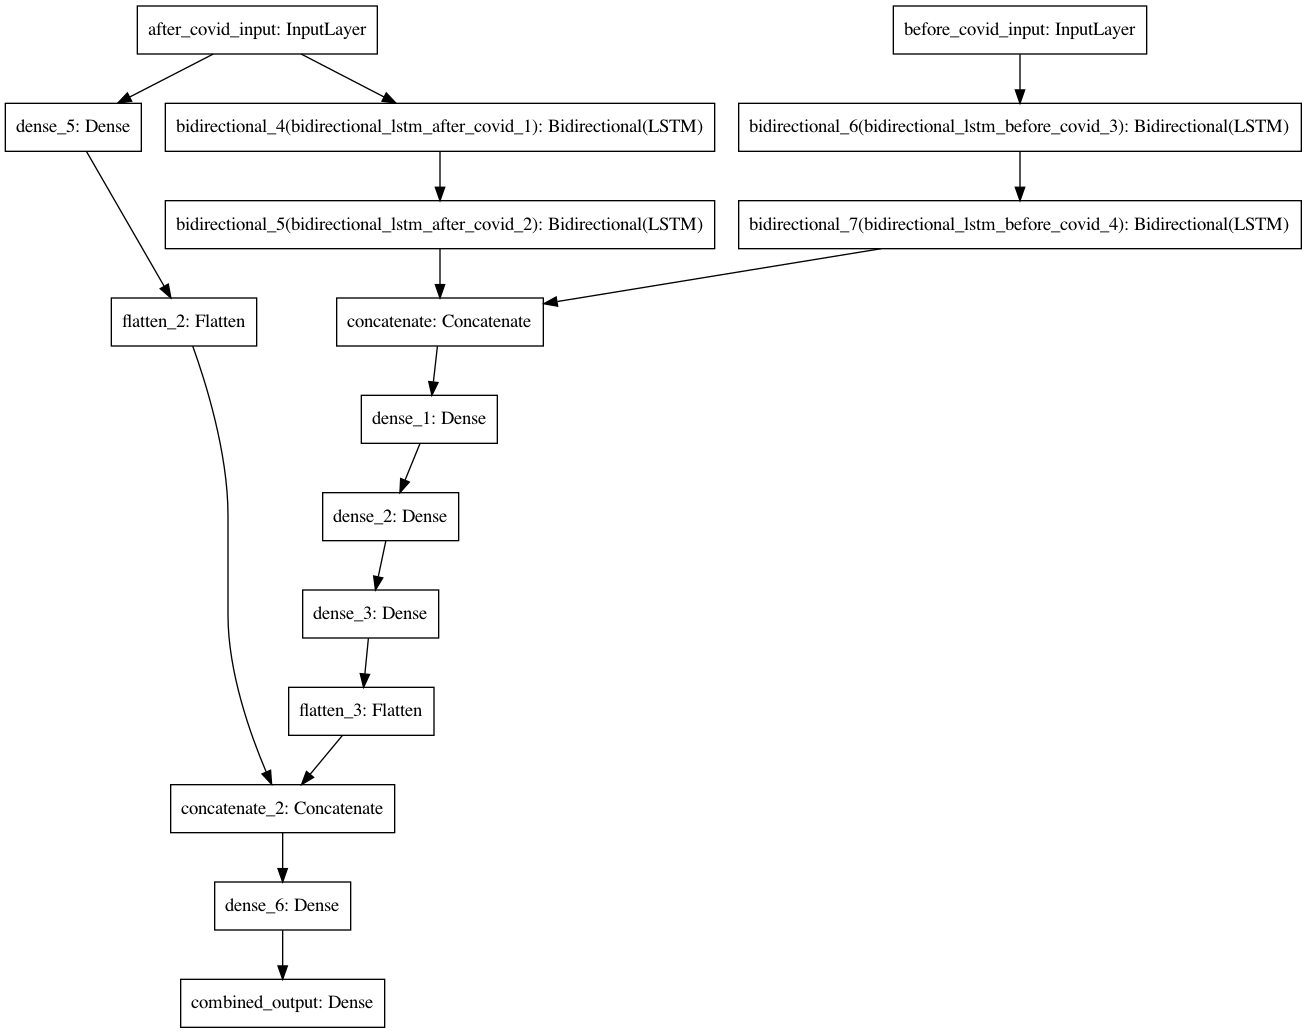

In [14]:
from tensorflow.python.keras.models import Sequential
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten
print('Building Multitask Model...')

# Input layer
before_covid_input = Input(shape=(20,before__covid_columns), name='before_covid_input')
print("before_covid_input shape: "+str(before_covid_input.shape))
after_covid_input = Input(shape=(20,after__covid_columns), name='after_covid_input')
dense_5 = Dense(96, activation='relu',name='dense_5',kernel_regularizer=my_regulizer)(after_covid_input)
flatten_1 = Flatten()(dense_5)

print("after_covid_input shape: "+str(after_covid_input.shape))

# second layer
#conv1d_before_covid = Conv1D(32, 3, activation='relu',name='conv1d_before_covid')(before_covid_input)

#print("conv1d_before_covid shape: "+str(conv1d_before_covid.shape))
#maxpool_before_covid = MaxPool1D(name='maxpool_before_covid')(conv1d_before_covid)
#print("maxpool_before_covid shape: "+str(maxpool_before_covid.shape))

# second layer
bidirectional_lstm_after_covid_1 = Bidirectional(LSTM(32, return_sequences=True, stateful=False,name='bidirectional_lstm_after_covid_1'), merge_mode='concat')(after_covid_input)
print("bidirectional_lstm_after_covid_1 shape: "+str(bidirectional_lstm_after_covid_1.shape))
bidirectional_lstm_after_covid_2 = Bidirectional(LSTM(16, return_sequences=True, stateful=False,name='bidirectional_lstm_after_covid_2'), merge_mode='concat')(bidirectional_lstm_after_covid_1)
print("bidirectional_lstm_after_covid_2 shape: "+str(bidirectional_lstm_after_covid_2.shape))

bidirectional_lstm_before_covid_3 = Bidirectional(LSTM(32, return_sequences=True, stateful=False,name='bidirectional_lstm_before_covid_3'), merge_mode='concat')(before_covid_input)
print("bidirectional_lstm_before_covid_3 shape: "+str(bidirectional_lstm_before_covid_3.shape))
bidirectional_lstm_before_covid_4 = Bidirectional(LSTM(16, return_sequences=True, stateful=False,name='bidirectional_lstm_before_covid_4'), merge_mode='concat')(bidirectional_lstm_before_covid_3)
print("bidirectional_lstm_before_covid_4 shape: "+str(bidirectional_lstm_before_covid_4.shape))


# Combine 2 layers into 1
#concatenate = Concatenate(name='concatenate')([before_covid_input, after_covid_input])
# [(None, 20, 100), (None, 9, 32)]
concatenate = Concatenate(name='concatenate',axis=1)([bidirectional_lstm_after_covid_2, bidirectional_lstm_before_covid_4])

#bidirectional_lstm_common = Bidirectional(LSTM(50, return_sequences=True, stateful=False,name='lstm'), merge_mode='concat')(concatenate)
#dropout_1 = Dropout(0.5, name='dropout_1')(concatenate)
#bidirectional_lstm_common_2 = Bidirectional(LSTM(10, kernel_initializer="uniform",return_sequences=False, name='lstm2'),merge_mode='concat')(dropout_1)

print(concatenate.shape)

dense_1 = Dense(32, activation='relu',name='dense_1', kernel_regularizer=my_regulizer)(concatenate)
print(dense_1.shape)
dense_2 = Dense(32, activation='relu',name='dense_2',kernel_regularizer=my_regulizer)(dense_1)
print(dense_2.shape)
dense_3 = Dense(96, activation='relu',name='dense_3',kernel_regularizer=my_regulizer)(dense_2)
flatten_2 = Flatten()(dense_3)
#dense_4 = Dense(14, activation='relu',name='dense_4',kernel_regularizer=my_regulizer)(dense_3)

print(dense_3.shape)

concatenate_2 = Concatenate(name='concatenate_2',axis=1)([flatten_2, flatten_1])
dense_6 = Dense(96, activation='relu',name='dense_6',kernel_regularizer=my_regulizer)(concatenate_2)


    
# sequence output
combined_output = Dense(1, activation='linear',name='combined_output')(dense_6)

# output
multitask_before_after_model_2 = Model(inputs=[before_covid_input,after_covid_input], outputs=[combined_output])
# summarize layers
print(multitask_before_after_model_2.summary())

multitask_before_after_model_2.compile(loss="mse", optimizer=my_optimizer, metrics=['mse', 'mae', 'mape'])
tensorflow.keras.utils.plot_model(multitask_before_after_model_2)

In [15]:
import time
start = time.time()
####### TO-DO ADD EARLY STOPPING to reduce overfitting
multitask_before_after_model_2_history = multitask_before_after_model_2.fit([full_before_covid_trainX, full_after_covid_trainX], [full_after__covid_trainY], batch_size=my_batch_size, epochs=my_epochs, verbose=1, shuffle=my_shuffle,  validation_split=my_validation_split)
print("> Compilation Time : ", time.time() - start)

Epoch 1/50
4988/4988 [==============================] - 227s 44ms/step - loss: 0.1421 - mse: 0.1421 - mae: 0.1282 - mape: 11.3131 - val_loss: 0.0146 - val_mse: 0.0145 - val_mae: 0.0806 - val_mape: 6.0324
Epoch 2/50
4988/4988 [==============================] - 220s 44ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0610 - mape: 5.2384 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0635 - val_mape: 4.9345
Epoch 3/50
4988/4988 [==============================] - 211s 42ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0548 - mape: 4.6783 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0673 - val_mape: 5.3094
Epoch 4/50
4988/4988 [==============================] - 213s 43ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0512 - mape: 4.3472 - val_loss: 0.0127 - val_mse: 0.0126 - val_mae: 0.0697 - val_mape: 5.1962
Epoch 5/50
4988/4988 [==============================] - 212s 43ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0491 - mape: 4.1582 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0664 - v

4988/4988 [==============================] - 184s 37ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0423 - mape: 3.5358 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0590 - val_mape: 4.5239
Epoch 42/50
4988/4988 [==============================] - 185s 37ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0426 - mape: 3.5530 - val_loss: 0.0106 - val_mse: 0.0105 - val_mae: 0.0576 - val_mape: 4.3510
Epoch 43/50
4988/4988 [==============================] - 184s 37ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0424 - mape: 3.5362 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0607 - val_mape: 4.4972
Epoch 44/50
4988/4988 [==============================] - 185s 37ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0423 - mape: 3.5357 - val_loss: 0.0112 - val_mse: 0.0111 - val_mae: 0.0597 - val_mape: 4.4894
Epoch 45/50
4988/4988 [==============================] - 185s 37ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0424 - mape: 3.5425 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0616 - val_mape:

## 4.3 Model scores

In [19]:
print ("---------------------------- TRAINING SCORES ----------------------------")
print ("House\t\t\tError Metric\t\tScore")
print ("---------------------------------------------------------------")
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MSE', multitask_before_after_model_history.history['mse'][-1]))
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAE', multitask_before_after_model_history.history['mae'][-1]))
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAPE', multitask_before_after_model_history.history['mape'][-1]))
print("\n\n")
print ("---------------------------- TESTING SCORES ----------------------------")
print ("House\t\t\tError Metric\t\tScore")
print ("---------------------------------------------------------------")
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MSE', multitask_before_after_model_history.history['val_mse'][-1]))
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAE', multitask_before_after_model_history.history['val_mae'][-1]))
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAPE', multitask_before_after_model_history.history['val_mape'][-1]))

---------------------------- TRAINING SCORES ----------------------------
House			Error Metric		Score
---------------------------------------------------------------
PUNE 1:			MSE		0.006233
PUNE 1:			MAE		0.042255
PUNE 1:			MAPE		3.521321



---------------------------- TESTING SCORES ----------------------------
House			Error Metric		Score
---------------------------------------------------------------
PUNE 1:			MSE		0.010495
PUNE 1:			MAE		0.061298
PUNE 1:			MAPE		4.696801


In [20]:
print ("---------------------------- TRAINING SCORES ----------------------------")
print ("House\t\t\tError Metric\t\tScore")
print ("---------------------------------------------------------------")
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MSE', min(multitask_before_after_model_history.history['mse'])))
print("At index: "+ str(multitask_before_after_model_history.history['mse'].index(min(multitask_before_after_model_history.history['mse']))))
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAE', min(multitask_before_after_model_history.history['mae'])))
print("At index: "+ str(multitask_before_after_model_history.history['mae'].index(min(multitask_before_after_model_history.history['mae']))))

print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAPE', min(multitask_before_after_model_history.history['mape'])))
print("At index: "+ str(multitask_before_after_model_history.history['mape'].index(min(multitask_before_after_model_history.history['mape']))))

print("\n\n")
print ("---------------------------- TESTING SCORES ----------------------------")
print ("House\t\t\tError Metric\t\tScore")
print ("---------------------------------------------------------------")
print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MSE', min(multitask_before_after_model_history.history['val_mse'])))
print("At index: "+ str(multitask_before_after_model_history.history['val_mse'].index(min(multitask_before_after_model_history.history['val_mse']))))

print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAE', min(multitask_before_after_model_history.history['val_mae'])))
print("At index: "+ str(multitask_before_after_model_history.history['val_mae'].index(min(multitask_before_after_model_history.history['val_mae']))))

print ("%s:\t\t\t%s\t\t%f" % ('PUNE 1', 'MAPE', min(multitask_before_after_model_history.history['val_mape'])))
print("At index: "+ str(multitask_before_after_model_history.history['val_mape'].index(min(multitask_before_after_model_history.history['val_mape']))))


---------------------------- TRAINING SCORES ----------------------------
House			Error Metric		Score
---------------------------------------------------------------
PUNE 1:			MSE		0.006233
At index: 49
PUNE 1:			MAE		0.042255
At index: 49
PUNE 1:			MAPE		3.521167
At index: 47



---------------------------- TESTING SCORES ----------------------------
House			Error Metric		Score
---------------------------------------------------------------
PUNE 1:			MSE		0.010390
At index: 41
PUNE 1:			MAE		0.059318
At index: 36
PUNE 1:			MAPE		4.447128
At index: 36


In [21]:
print(len(x_test_before_covid_list))
print(len(x_test_after_covid_list))
print(len(y_test_after_covid_list))

print(x_test_before_covid_list[0][1517:,:,:].shape)
print(x_test_after_covid_list[0].shape)
print(y_test_after_covid_list[0].shape)

38
38
38
(2610, 20, 8)
(2610, 20, 9)
(2610,)


In [22]:
mape_multitask_list = []
mse_multitask_list = []
mae_multitask_list = []


for x in range(38):
    metrics = multitask_before_after_model.evaluate([x_test_before_covid_list[x][1517:,:,:],x_test_after_covid_list[x]], y_test_after_covid_list[x], batch_size=128)
    mse_multitask_list.append(metrics[1])
    mae_multitask_list.append(metrics[2])
    mape_multitask_list.append(metrics[3])
    
print(len(mse_multitask_list))
print(len(mae_multitask_list))
print(len(mape_multitask_list))

21/21 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0471 - mape: 3.8870
38
38
38


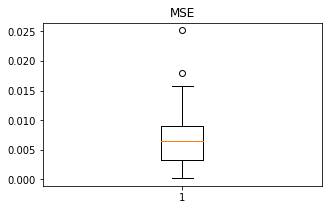

In [25]:
fig = plt.figure(figsize =(5, 3))

plt.title("MSE")
# Creating plot
plt.boxplot(mse_multitask_list)
 
# show plot
plt.show()

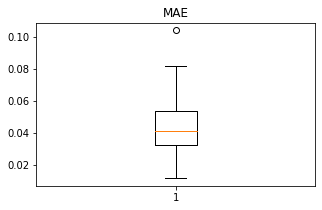

In [26]:
fig = plt.figure(figsize =(5, 3))

plt.title("MAE")
# Creating plot
plt.boxplot(mae_multitask_list)
 
# show plot
plt.show()

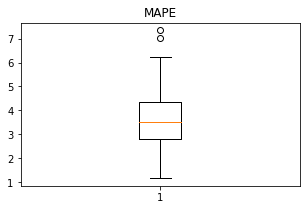

In [27]:
fig = plt.figure(figsize =(5, 3))

plt.title("MAPE")
# Creating plot
plt.boxplot(mape_multitask_list)
 
# show plot
plt.show()